In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(42)

In [2]:
features = 'more_features.csv'
raw_features = pd.read_csv(features, parse_dates = ['Date'], index_col = 'Date')
raw_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324 entries, 2021-06-01 to 2022-04-20
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   neg          324 non-null    float64
 1   neu          324 non-null    float64
 2   pos          324 non-null    float64
 3   comp         324 non-null    float64
 4   count_tweet  324 non-null    int64  
 5   TEU-ENG      324 non-null    float64
 6   TEU-USA      324 non-null    float64
 7   TEU-WGT      324 non-null    float64
 8   TEU-SCA      324 non-null    float64
 9   TMU-ENG      324 non-null    float64
 10  TMU-USA      324 non-null    float64
 11  TMU-WGT      324 non-null    float64
 12  TMU-SCA      324 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 35.4 KB


In [3]:
twitter_features = raw_features.iloc[:, :5].copy()
index_features = raw_features.iloc[:, 5:].copy()
index_features = index_features[['TEU-ENG', 'TEU-USA', 'TMU-ENG', 'TMU-USA']].copy()
index_features

,TEU-ENG,TEU-USA,TMU-ENG,TMU-USA
Date,,,,
2021-06-01,98.598914,77.501714,100.339039,100.487305
2021-06-02,94.105630,65.738278,96.322890,75.716336
2021-06-03,91.738407,99.035407,102.172532,88.370691
2021-06-04,99.025737,83.751354,145.015820,83.162778
2021-06-05,91.376452,99.040368,158.555656,116.197078
...,...,...,...,...
2022-04-16,140.872030,68.090253,182.339005,75.186344
2022-04-17,187.669652,138.709254,206.254297,44.343769
2022-04-18,128.737714,88.825799,134.996579,56.195069


In [8]:
file = 'BTC-USD.csv'
raw_data = pd.read_csv(file, parse_dates = ['Date'], index_col = 'Date')
df = raw_data.copy()
columns = df.columns.to_list()
columns
# columns = ['Close', 'High', 'Low', 'Open', 'Volume']
columns = ['Close']
df = df[columns].copy()

In [9]:
df.columns

Index(['Close'], dtype='object')

In [10]:
# df = df.merge(index_features, on='Date').copy()
df = df.merge(twitter_features, on='Date').copy()


In [11]:
df.columns

Index(['Close', 'neg', 'neu', 'pos', 'comp', 'count_tweet'], dtype='object')

In [12]:
# Save new data for forecasting 
X_new = df.loc['2022-02-20' : , : ].copy()
Y_new = X_new.loc[:, 'Close'].copy()
X_new = X_new.drop("Close", axis=1)

#Subset dataset for train and validate
df = df.loc[ : '2022-02-20'].copy()
df = df.copy()

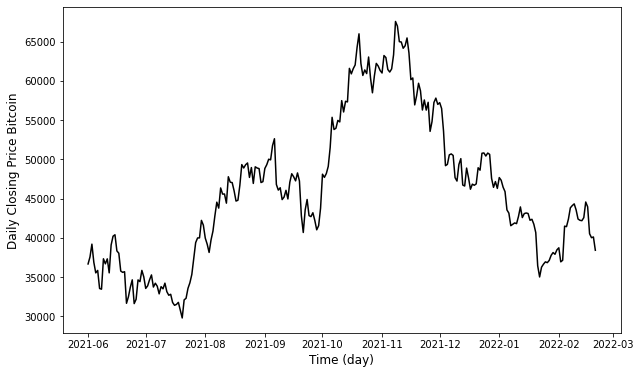

In [13]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label, y_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12})
    plt.ylabel(y_label, {'fontsize': 12})
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/1.jpg', format='jpg', dpi=1000)

timeseries(df.index, df['Close'], 'Time (day)', 
           'Daily Closing Price Bitcoin')

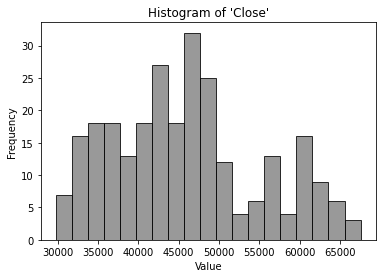

In [14]:
def plot_histogram(x):
    plt.hist(x, bins = 19, alpha=0.8, color = 'gray', edgecolor = 'black')
    plt.title("Histogram of '{var_name}'".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plot_histogram(df['Close'])

In [15]:
# Outlier detection
up_b = df['Close'].mean() + 2*df['Close'].std()
low_b = df['Close'].mean() - 2*df['Close'].std()

# Replace outlier by interpolation for base consumption
df.loc[df['Close'] > up_b, 'Close'] = np.nan
df.loc[df['Close'] < low_b, 'Close'] = np.nan
df['Close'].interpolate(inplace=True)

Dimension of train data:  (212, 6)
Dimension of test data:  (53, 6)


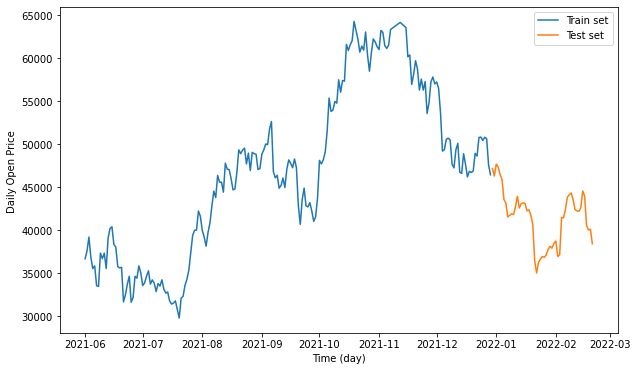

In [16]:
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.Close)
plt.plot(test_dataset.Close)
plt.xlabel('Time (day)')
plt.ylabel('Daily Open Price ')
plt.legend(['Train set', 'Test set'], loc='upper right')
# plt.savefig('C:/Users/Malik Rigot/Desktop/Tilburg/Master/Thesis/Code/figures.jpg', format='jpg', dpi=1000)

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [17]:
# Split train data to X and y
X_train = train_dataset.drop('Close', axis = 1)
y_train = train_dataset.loc[:,['Close']]

# Split test data to X and y
X_test = test_dataset.drop('Close', axis = 1)
y_test = test_dataset.loc[:,['Close']]

In [18]:
# Transform X_train, y_train, X_test and y_test

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [19]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 30

X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape)

X_train.shape:  (23, 30, 5)
y_train.shape:  (182, 1)
X_test.shape:  (23, 30, 5)
y_test.shape:  (182, 1)


In [20]:
# Create SimplRNN model
def create_VanillaRNN(units):
    model = Sequential()
    model.add(SimpleRNN(units=units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    #compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# Create SimplRNN model
def create_LayerRNN(units):
    model = Sequential()
    model.add(SimpleRNN(units=units, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(Dense(8, activation="relu")) 
    model.add(Dense(1))
    #compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    # First layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Second layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# Create LSTM or GRU model 
def create_model(units, m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Second layer of LSTM
    model.add(m (units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model




#Vanilla RNN
model_rnn = create_VanillaRNN(64)

#Layered RNN
model_layer_rnn = create_LayerRNN(64)

# BiLSTM
model_bilstm = create_model_bilstm(64)

# GRU and LSTM 
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)

In [21]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

    # shuffle = False because the order of the data matters
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

history_vanillarnn = fit_model(model_rnn)
history_layerrnn = fit_model(model_layer_rnn)
history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/100
5/5 [==============================] - 1s 60ms/step - loss: 0.1138 - val_loss: 0.1703
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 0.2831 - val_loss: 0.0194
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 0.1607 - val_loss: 0.0540
Epoch 4/100
5/5 [==============================] - 0s 12ms/step - loss: 0.1105 - val_loss: 0.0296
Epoch 5/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0763 - val_loss: 0.0163
Epoch 6/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0957 - val_loss: 0.0181
Epoch 7/100
5/5 [==============================] - 0s 11ms/step - loss: 0.1032 - val_loss: 0.0163
Epoch 8/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0891 - val_loss: 0.0200
Epoch 9/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0709 - val_loss: 0.0154
Epoch 10/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0713 - val_loss: 0.0157
Epoch 11/100
5/5 [=

In [22]:
df.columns

Index(['Close', 'neg', 'neu', 'pos', 'comp', 'count_tweet'], dtype='object')

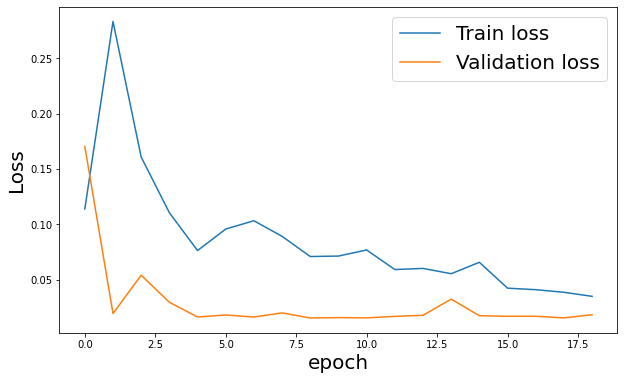

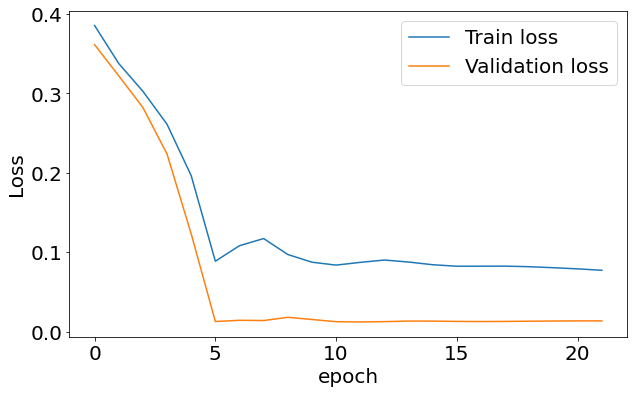

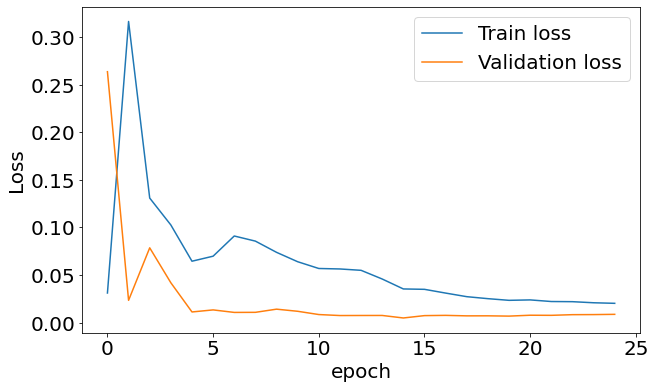

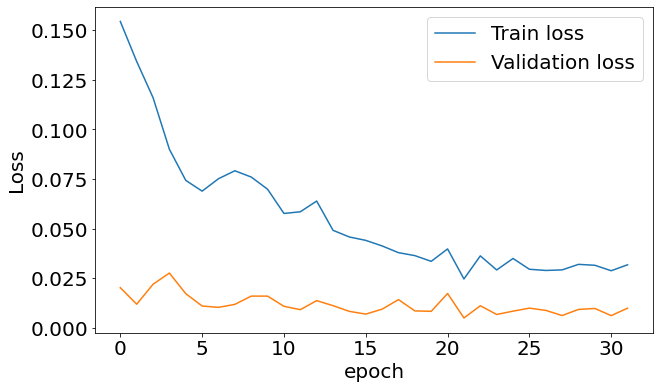

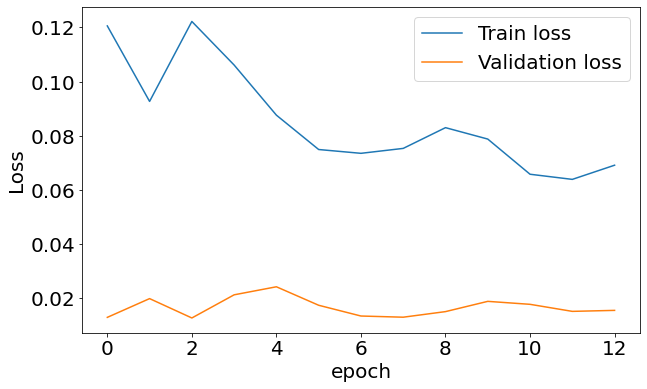

In [23]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
   
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    # plt.title('Model Train vs Validation Loss for ' + model_name, fontsize=18)
    plt.ylabel('Loss', fontsize=20)
    plt.xlabel('epoch', fontsize=20)
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.legend(['Train loss', 'Validation loss'], loc='upper right', fontsize=20)
    plt.savefig('C:/Users/Malik Rigot/Desktop/Tilburg/Master/Thesis/Code/figures/sentiment/SENT-new-'+model_name+'.jpg', format='jpg', dpi=1000)


plot_loss(history_vanillarnn, "Vanilla RNN")
plot_loss(history_layerrnn, 'Layered RNN')
plot_loss (history_bilstm, 'BiLSTM')
plot_loss (history_lstm, 'LSTM')
plot_loss (history_gru, 'GRU')

In [20]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [21]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_vanilla_rnn = prediction(model_rnn)
prediction_layer_rnn = prediction(model_layer_rnn)
prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

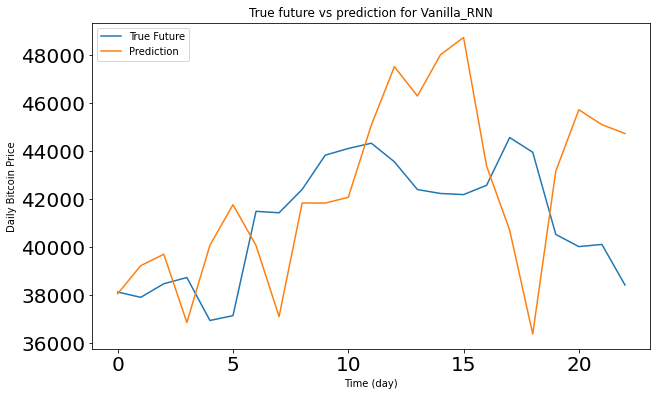

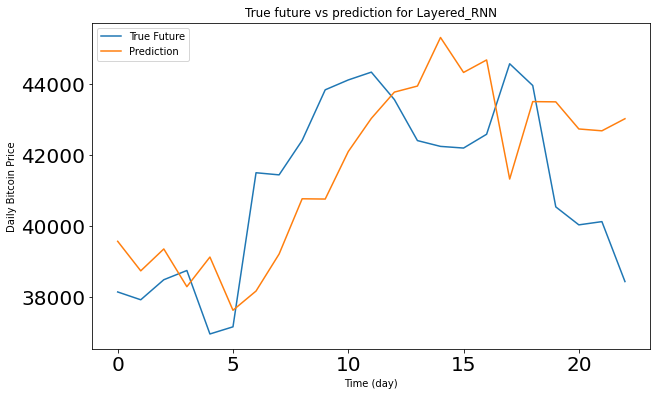

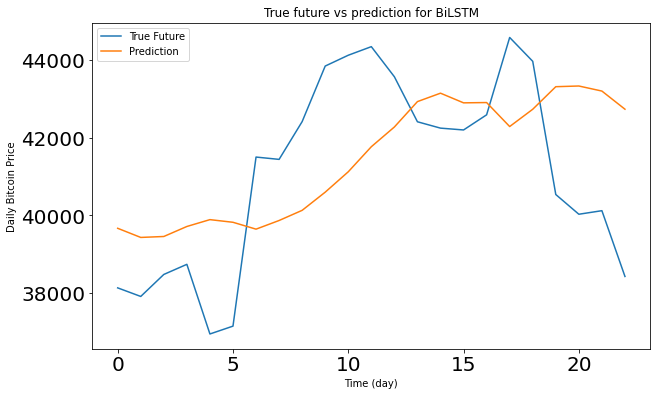

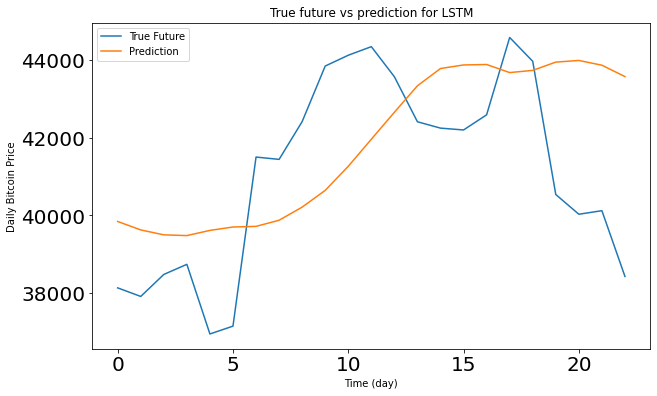

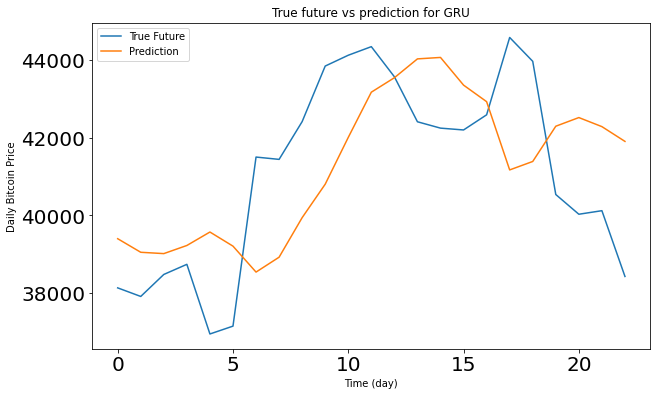

In [22]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily Bitcoin Price')
    plt.savefig('C:/Users/Malik Rigot/Desktop/Tilburg/Master/Thesis/Code/figures/all_features/ALL-predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    


plot_future(prediction_vanilla_rnn, 'Vanilla_RNN', y_test)    
plot_future(prediction_layer_rnn, 'Layered_RNN', y_test)    
plot_future(prediction_bilstm, 'BiLSTM', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)

In [23]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')


evaluate_prediction(prediction_vanilla_rnn, y_test, 'Vanilla RNN')
evaluate_prediction(prediction_layer_rnn, y_test, 'Layered RNN')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

Vanilla RNN:
Mean Absolute Error: 3278.1710
Root Mean Square Error: 3911.3826

Layered RNN:
Mean Absolute Error: 1974.3302
Root Mean Square Error: 2265.4414

Bidirectional LSTM:
Mean Absolute Error: 1991.6267
Root Mean Square Error: 2246.7660

LSTM:
Mean Absolute Error: 2089.7660
Root Mean Square Error: 2399.7819

GRU:
Mean Absolute Error: 1876.4214
Root Mean Square Error: 2108.7426



In [24]:
# Plot histoy and future data
def plot_history_future(y_train, prediction, model_name):
    
    plt.figure(figsize=(10, 6))
    
    range_history = len(y_train)
    range_future = list(range(range_history, range_history + len(prediction)))

    plt.plot(np.arange(range_history), np.array(y_train), label='History')
    plt.plot(range_future, np.array(prediction),label='Prediction')
    # plt.plot(range_future, np.array(Y_new),label='True')

    plt.title('History and prediction for ' + model_name)
    plt.legend(loc='upper right')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily Open Price Bitcoin')
    plt.savefig('C:/Users/Malik Rigot/Desktop/Tilburg/Master/Thesis/Code/figures/all_features/ALL-Future-Pred.jpg', format='jpg', dpi=1000)

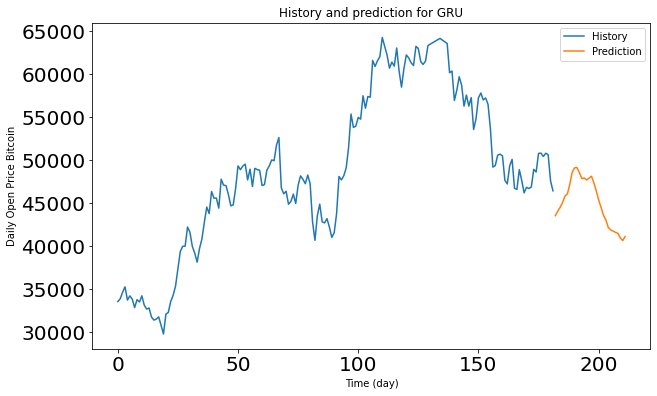

In [25]:
def forecast(X_input, time_steps):
    # Scale the unseen input with the scaler fitted on the training data
    X = input_scaler.transform(X_input)
    # Reshape unseen data to a 3D input
    Xs = []
    for i in range(len(X) - time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        
    X_transformed = np.array(Xs)

    # Make prediction for unseen data using LSTM model 
    prediction = model_gru.predict(X_transformed)
    prediction_actual = scaler_y.inverse_transform(prediction)
    return prediction_actual


prediction = forecast(X_new, TIME_STEPS)
plot_history_future(y_train, prediction,'GRU')


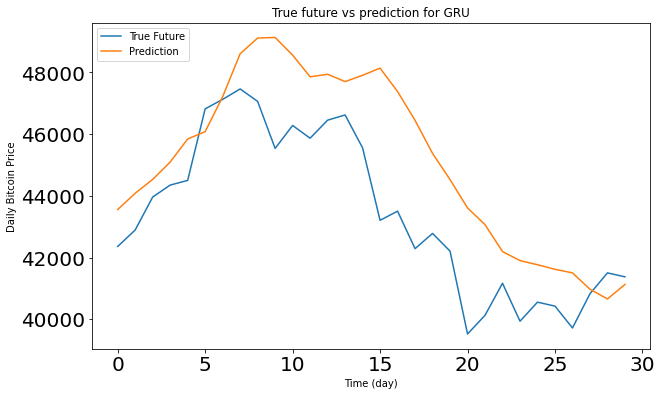

In [26]:
plot_future(prediction, 'GRU', Y_new[30:])

In [38]:
prediction = prediction.flatten()

In [39]:
Y_new.shape

(60,)

In [40]:
evaluate_prediction(prediction, Y_new[30:], 'GRU')

GRU:
Mean Absolute Error: 1839.6822
Root Mean Square Error: 2225.2758

